In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  %pip install --quiet git+https://github.com/raultruco/cryptowatson-indicators#egg=cryptowatson-indicators

import backtrader as bt
from cryptowatson_indicators.backtrader import RebalanceStrategy, WeightedDCAStrategy, DCAStrategy, HodlStrategy
from cryptowatson_indicators.datas import TickerDataSource
from cryptowatson_indicators.indicators import FngBandIndicator, RainbowBandIndicator
from tabulate import tabulate
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200
# %matplotlib inline
%matplotlib widget

# Global variables
# Data sources
ticker_data_source = TickerDataSource().load()

# Compare strategies

Usage...

### Variables

In [2]:
# Common variables
# ticker_symbol        = "BTCUSDT"    # currently only works with BTCUSDT
start                = '01/01/2021'   # start date of the simulation. Ex: '01/08/2020' or None
end                  = None # '31/12/2021'           # end date of the simulation. Ex: '01/08/2020' or None
initial_cash         = 10000.0        # initial broker cash. Default 10000 usd
min_order_period     = 3              # Minimum period in days to place orders
base_buy_amount  = 100            # Amount purchased in standard DCA


# Specific for Fear and greed indicator
fng_weighted_multipliers = [1.5, 1.25, 1, 0.75, 0.5]    # buy amount multipliers (weighted) for each band
fng_rebalance_percents   = [85, 65, 50, 15, 10]         # rebalance percentages of BTC / total for each band
fng_indicator_params = {}             # parameters for FnG indicator

# Specific for Rainbow indicator
rainbow_weighted_multipliers = [0, 0.1, 0.2, 0.3, 0.5, 0.8, 1.3, 2.1, 3.4]
rainbow_rebalance_percents = [10, 20, 30, 40, 50, 60, 70, 80, 90]
rainbow_indicator_params = {}             # parameters for FnG indicator

# Other options
log_progress         = False
plot_results         = False

### Run strategies!

In [3]:
def run(strategy_class, **kwargs):
    cerebro = bt.Cerebro(stdstats=False, runonce=True)
    cerebro.broker.set_coc(True)

    # Add strategy
    cerebro.addstrategy(strategy_class, **kwargs)

    # Add data feeds
    cerebro.adddata(ticker_data_source.to_backtrade_feed(start, end))

    # Set broker initial cash
    cerebro.broker.setcash(initial_cash)

    # Run simulation!
    cerebro_results = cerebro.run()     # runonce=False, exactbars=True (optimization)
    print(f"✔ Done {str(cerebro_results[0])}")

    return cerebro_results[0]


all_run_results = list()

# Weighted Av strategy with Fear and Greed indicator
run_result = run(
    strategy_class=WeightedDCAStrategy, \
    indicator_class=FngBandIndicator, \
    indicator_params=fng_indicator_params, \
    base_buy_amount=base_buy_amount, \
    min_order_period=min_order_period, \
    weighted_multipliers=fng_weighted_multipliers, \
    log=log_progress, \
)
all_run_results.append(run_result)

# Rainbow Weighted Av strategy
run_result = run( \
    strategy_class=WeightedDCAStrategy, \
    indicator_class=RainbowBandIndicator, \
    indicator_params=rainbow_indicator_params, \
    base_buy_amount=base_buy_amount, \
    min_order_period=min_order_period, \
    weighted_multipliers=rainbow_weighted_multipliers, \
    log=log_progress, \
)
all_run_results.append(run_result)

# Fear and Greed Rebalance strategy
run_result = run( \
    strategy_class=RebalanceStrategy, \
    indicator_class=FngBandIndicator, \
    indicator_params=fng_indicator_params, \
    min_order_period=min_order_period, \
    rebalance_percents=fng_rebalance_percents, \
    log=log_progress, \
)
all_run_results.append(run_result)

# Rainbow Rebalance strategy
run_result = run( \
    strategy_class=RebalanceStrategy, \
    indicator_class=RainbowBandIndicator, \
    indicator_params=rainbow_indicator_params, \
    min_order_period=min_order_period, \
    rebalance_percents=rainbow_rebalance_percents, \
    log=log_progress, \
)
all_run_results.append(run_result)

# Standard DCA
run_result = run( \
    strategy_class=DCAStrategy, \
    buy_amount=base_buy_amount, \
    min_order_period=min_order_period, \
    log=log_progress, \
)
all_run_results.append(run_result)

# HODL
run_result = run( \
    strategy_class=HodlStrategy, \
    percent=100, \
    log=log_progress, \
)
all_run_results.append(run_result)

# Sort results by pnl_value
sorted_run_results = sorted(all_run_results, key=lambda strategy: float(strategy.pnl_value), reverse=True)

✔ Done Weighted DCA Fear and Greed
✔ Done Weighted DCA Rainbow
✔ Done Rebalance Fear and Greed
✔ Done Rebalance Rainbow
✔ Done DCA 100.00$
✔ Done HODL 100%


### Show the results

In [4]:

column_keys = ['name', 'pnl_value', 'pnl_percent']
column_headers = ['Strategy', 'PNL USDT', 'PNL %']
sorted_run_details = map(lambda strategy: strategy.describe(keys=column_keys), sorted_run_results)
print(tabulate([details.values() for details in sorted_run_details], 
                tablefmt="github", 
                headers=column_headers, 
                floatfmt=".2f"))

| Strategy                    |   PNL USDT |   PNL % |
|-----------------------------|------------|---------|
| Rebalance Rainbow           |    -894.65 |   -8.95 |
| HODL 100%                   |   -2547.96 |  -25.48 |
| Rebalance Fear and Greed    |   -3859.25 |  -38.59 |
| Weighted DCA Rainbow        |   -4752.72 |  -47.53 |
| Weighted DCA Fear and Greed |   -4950.28 |  -49.50 |
| DCA 100.00$                 |   -5034.77 |  -50.35 |


### Plot results

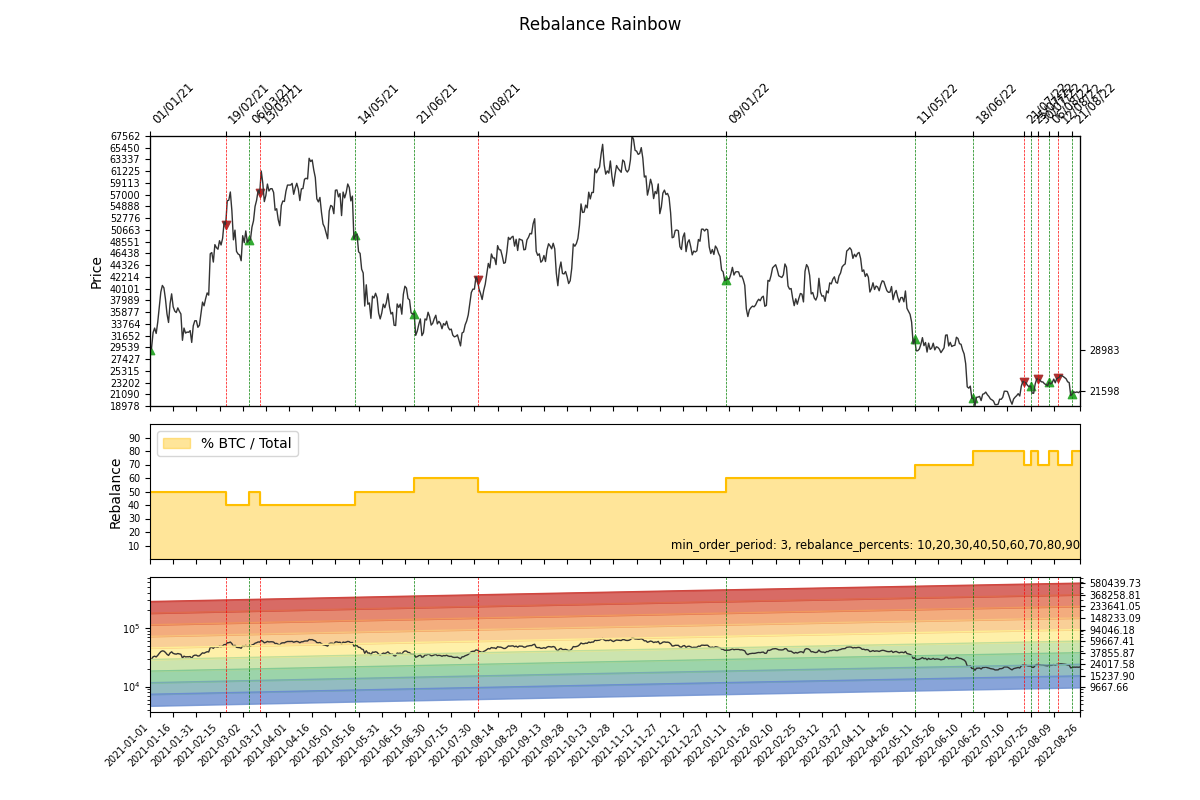

In [5]:
plot_results = True
plot_only_winner = True

if plot_results:
    for i in range(0, len(sorted_run_results)):
        sorted_run_results[i].plot()

        if plot_only_winner:
            break
